# Monte Carlo Simulation for Asian Options

An Asian option is a type of derivative that is based on the average price of an underlying asset over a specific period, rather than the price of the underlying asset at a single point in time (like European or American options). This averaging feature makes Asian options less susceptible to manipulation of the asset's price right before expiration, unlike traditional options, where a sudden price spike can dramatically change the option's value. For example, if a company suddenly announces a significant development (like implementing AI), the stock price could spike, making traditional call options drastically increase in value. However, since the payoff of an Asian option depends on the average price of the stock, it is less affected by such short-term fluctuations, making it harder to manipulate. Moreover, because the payoff depends on the average price, the volatility is reduced, which makes Asian options cheaper than European or American options. For an **arithmetic** Asian call option, The payoff of an arithmetic Asian option is given by:

$$ \text{Payoff}_{\text{call}} = \max\left(\frac{1}{M} \sum_{i=1}^{M} S(t_i) - K, 0\right) $$

Where:
- $S(t_i)$ is the underlying asset price at time $t_i$,
- $K$ is the strike price,
- $M$ is the number of time intervals.

The evolution of asset prices follows a geometric Brownian motion:

$$ dS_t = \mu S_t dt + \sigma S_t dW_t $$

Where:
- $S_t$ is the asset price at time $t$,
- $\mu$ is the drift rate (expected return),
- $\sigma$ is the volatility of the asset,
- $W_t$ is a Wiener process (also called Brownian motion), which is a stochastic process with the following properties:
  1. $W_0 = 0$,
  2. The increments $W_{t+\Delta t} - W_t$ are normally distributed with mean $0$ and variance $\Delta t$,
  3. The increments are independent over disjoint intervals.

For simulation purposes, we discretize the continuous GBM model as:

$$ S_{t+1} = S_t \exp\left(\left(\mu - \frac{1}{2} \sigma^2\right) \Delta t + \sigma \sqrt{\Delta t} Z\right) $$

Where:
- $\Delta t$ is the time step size,
- $Z \sim \mathcal{N}(0,1)$ is a standard normal random variable.

Finally, the Monte Carlo price estimate for the Asian option is given by:

$$ \hat{V}_{\text{Asian}} = e^{-rT} \frac{1}{N} \sum_{i=1}^{N} \max\left(A_i - K, 0\right) $$

Where:
- $A_i = \frac{1}{M} \sum_{j=1}^{M} S_{i}(t_j)$ is the arithmetic average of the asset price for the $i$-th simulation,
- $r$ is the risk-free rate,
- $T$ is the time to maturity,
- $K$ is the strike price,
- $N$ is the number of Monte Carlo paths.

Note that in the explanation above, we used $\mu$ to represent the drift rate in the real world. However, in the code implementation, we are assuming we are under risk-neutral pricing dynamics. This means that we replace the real-world drift rate $\mu$ with the risk-free rate $r$.

The reason for using $r$ in place of $\mu$ is rooted in the concept of **risk-neutral pricing**. Under the risk-neutral measure, investors are indifferent to risk, and the expected growth rate of the underlying asset is the risk-free rate $r$, rather than the real-world drift $\mu$. Therefore, when pricing derivatives, we work in this risk-neutral framework to ensure there are no-arbitrage opportunities. This is the same principle that is applied in the BSM model, where the pricing formula for options uses $r$ (the risk-free rate) instead of $\mu$ (the real-world drift). In the BSM model, the option price is independent of $\mu$, given the current asset price $S_0$. This is because the current price $S_0$ already encapsulates the market's expectations of the asset's future behavior, including the drift $\mu$.




The final estimated price of the arithmetic Asian call option is: 4.1060 ± 0.0125


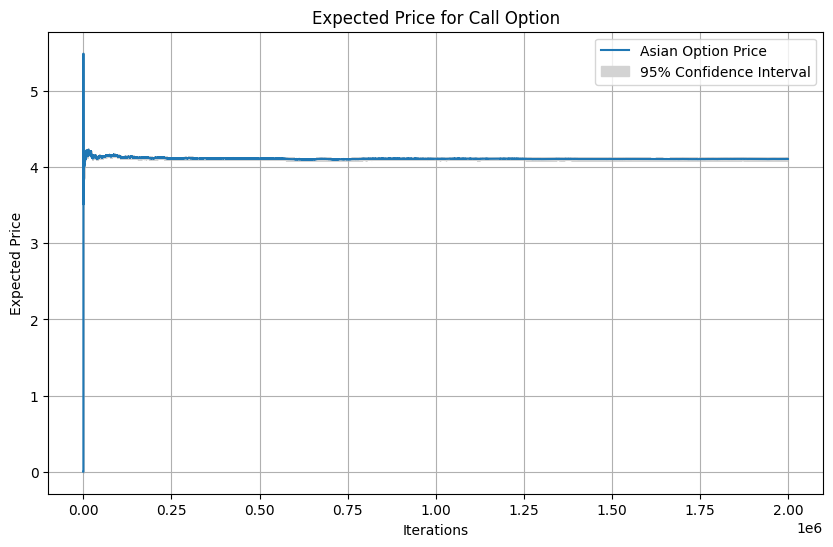

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def gbm(S0, r, sigma, T, M, N):
    dt = T / M
    paths = np.zeros((N, M + 1))
    paths[:, 0] = S0
    for t in range(1, M + 1):
        Z = np.random.standard_normal(N)
        paths[:, t] = paths[:, t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)
    return paths

def monte_carlo(S0, K, r, sigma, T, M, N, option_type='call'):
    paths = gbm(S0, r, sigma, T, M, N)
    average_price = np.mean(paths[:, 1:], axis=1)

    if option_type == 'call':
        payoffs = np.maximum(average_price - K, 0)
    elif option_type == 'put':
        payoffs = np.maximum(K - average_price, 0)
    else:
        raise ValueError("Invalid option type. Choose 'call' or 'put'.")

    discounted_payoff = np.exp(-r * T) * payoffs

    # Standard error
    standard_error = np.std(discounted_payoff) / np.sqrt(N)

    # We track the price evolution
    price_evolution = []
    cumulative_sum = 0

    for i in range(1, N + 1):
        cumulative_sum += discounted_payoff[i - 1]
        price_evolution.append(cumulative_sum / i)

    # The final price and standard error
    final_price = price_evolution[-1]

    return price_evolution, final_price, standard_error

# Parameters
S0 = 100
K = 110
r = 0.05
sigma = 0.3
T = 1
M = 252               # Number of trading days in a year
N = 2000000
option_type = 'call'  # Option type ('call' or 'put')

price_evolution, final_price, standard_error = monte_carlo(S0, K, r, sigma, T, M, N, option_type)

# For 95% confidence interval
confidence_interval = 1.96 * standard_error
print(f"The final estimated price of the arithmetic Asian {option_type} option is: {final_price:.4f} ± {confidence_interval:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(price_evolution, label="Asian Option Price")
plt.fill_between(range(len(price_evolution)),
                 np.array(price_evolution) - confidence_interval,
                 np.array(price_evolution) + confidence_interval,
                 color='lightgrey', label='95% Confidence Interval')
plt.title(f"Expected Price for {option_type.capitalize()} Option")
plt.xlabel("Iterations")
plt.ylabel("Expected Price")
plt.grid(True)
plt.legend()
plt.show()